In [18]:
%matplotlib inline

import numpy as np
import xarray as xr
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import geopandas as gpd
plt.rcParams['figure.figsize'] = (15,9)
from matplotlib.patches import Rectangle
from scipy.interpolate import griddata
import scipy.stats

In [31]:
import cartopy.crs as ccrs
import cartopy.crs as ccrs
from mpl_toolkits.basemap import Basemap

In [3]:
shapefile= gpd.read_file('greatlakes_subbasins.shp')

In [4]:
ds1 = xr.open_dataset('zg_Amon_MIROC-ES2L_historical_r1i1p1f2_gn_185001-201412.nc')
hgt = ds1.zg.sel(lat=slice(-9.87,87.88), lon=slice(182.5, 360),plev=slice(6) ,time=slice('1979-01-01','2014-12-31'))
lat_zg = ds1.lat.sel(lat=slice(-9.86,87.88))
lon_zg = ds1.lon.sel(lon=slice(182.5, 360))

In [5]:
hgt2d = hgt.values
ntime,nlevel, nrow_zg, ncol_zg = hgt2d.shape
print(nrow_zg,ncol_zg)

36 63


In [9]:
a= pd.read_csv("z_anom_miroc.csv")
b=pd.read_csv("miroc_anom_mean.csv")
a= a.drop(['Unnamed: 0'],axis=1)
b=b.drop(['Unnamed: 0'],axis=1)


b['mean']= b.mean(axis=1)
a_t= a.T

In [12]:
a_zg = PCA(n_components=9)
a_zg.fit(a_t)
a_reduced= a_zg.transform(a_t)
zg_f=a_zg.inverse_transform(a_reduced)
print(a_zg.explained_variance_ratio_.sum())

0.8499725828465324


In [13]:
rp= np.reshape(zg_f,(nrow_zg,ncol_zg,36),order='F')
range(rp.shape[0])

range(0, 36)

In [14]:
cor_mi= np.empty((nrow_zg,ncol_zg),dtype=object)
cor_mi[:] = np.nan
cor_mi_p= np.empty((nrow_zg,ncol_zg),dtype=object)
cor_mi_p[:] = np.nan

In [19]:
for i in range((rp.shape[0])):
    for j in range((rp.shape[1])):
        cor_mi[i,j] = scipy.stats.spearmanr(rp[i,j,],b['mean'])[0]
        
        

In [20]:
for i in range((rp.shape[0])):
    for j in range((rp.shape[1])):
        cor_mi_p[i,j] = scipy.stats.spearmanr(rp[i,j,],b['mean'])[1]
        

In [22]:
mi_sign= np.zeros([36,63])

In [23]:
for i in range(mi_sign.shape[0]):
    for j in range(mi_sign.shape[1]):
        if cor_mi_p[i,j]<0.1:
            mi_sign[i,j]= mi_sign[i,j]+1
        else:
            mi_sign[i,j]= mi_sign[i,j]+0

In [24]:
y,x=np.where(mi_sign>0)


In [25]:
x_list1= x.tolist()
y_list1=y.tolist()
lat_np= lat_zg.to_numpy()
lat_ls= lat_np.tolist()
lon_np=lon_zg.to_numpy()
lon_ls= lon_np.tolist()

In [26]:
lat_list1= []
for values in list(range(len(y_list1))):
    lat_list1.append(lat_ls[y_list1[values]])
    

In [27]:
lon_list1= []
for values in list(range(len(x_list1))):
    lon_list1.append(lon_ls[x_list1[values]])

In [28]:
xmax,ymin,xmin,ymax= shapefile.total_bounds
d1=xmax-xmin
d2=ymax-ymin
rect =Rectangle((xmin, ymin), d1, d2, facecolor="none", ec='k', lw=2)

In [29]:
cor_mi.max()

0.4007722007722008

C:\Users\tameem\AppData\Local\Temp\ipykernel_18188\2439310674.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  m.plot(lon_list1,lat_list1,'bo',markersize=1,color='k')


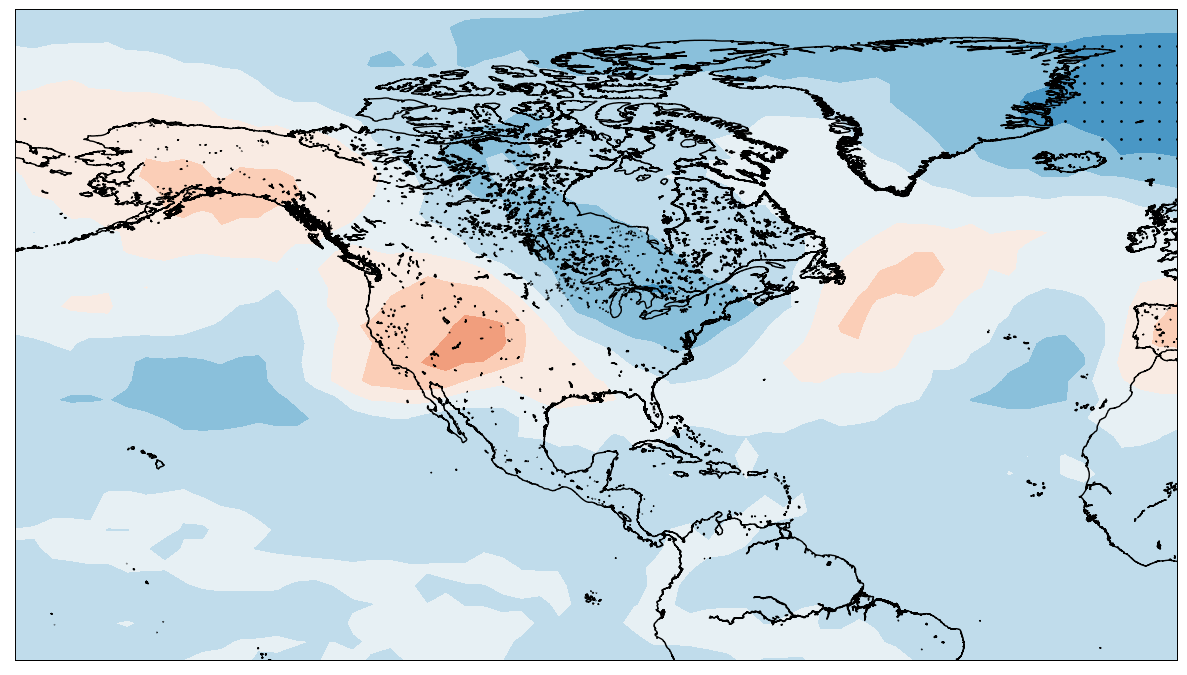

In [33]:
m = Basemap(projection='cyl', llcrnrlon=min(lon_zg), llcrnrlat=min(lat_zg),
        urcrnrlon=max(lon_zg), urcrnrlat=max(lat_zg),resolution='h')

x, y = m(*np.meshgrid(lon_zg,lat_zg))

cs = m.contourf(x,y,cor_mi,np.arange(-0.6,0.7,0.1), cmap='RdBu',extend='both')
m.plot(lon_list1,lat_list1,'bo',markersize=1,color='k')
m.drawcoastlines()
#m.drawcountries()
#cb = m.colorbar(cs)
circle = m.drawmapboundary(fill_color='k',color='k',linewidth=0.7)
circle.set_clip_on(False)
#cb.set_label('Correlation Co-efficient')
#plt.title('MIROC' ,size=20)
plt.savefig('PCA_MIROC.png')

In [28]:
b2d_pcs =  b

In [29]:
cca = CCA(n_components=4)
a_c, b_c = cca.fit_transform(b2d_pcs, a2d_pcs)

In [30]:
r=np.corrcoef(a_c[:, 0], b_c[:, 0])
r1=np.corrcoef(a_c[:, 1], b_c[:, 1])

In [31]:
r

array([[1.        , 0.62501594],
       [0.62501594, 1.        ]])

In [32]:
A = cca.x_weights_ 
B = cca.y_weights_
BB = np.reshape(B,(nrow_zg,ncol_zg,4),order='F')
BB_1= BB[:,:,0]


In [33]:
cca.x_weights_

array([[ 0.02395689, -0.00874261, -0.18228008,  0.36344907],
       [ 0.78141449, -0.35665528,  0.42835211,  0.19544866],
       [-0.5414589 , -0.54059302,  0.12944168,  0.41171958],
       [-0.13854053,  0.69999107,  0.5928191 ,  0.26865495],
       [-0.27648913, -0.30081934,  0.64428162, -0.35703141]])

In [34]:
shapefile['cca1']= A[:,0]
shapefile.head()

merge                                           geometry      cca1
0   lk_erie  POLYGON ((-80.27591 44.09303, -80.26687 44.085...  0.023957
1  lk_huron  POLYGON ((-79.85601 47.28073, -79.85985 47.239...  0.781414
2   lk_mich  POLYGON ((-86.11485 46.54744, -86.11092 46.546... -0.541459
3    lk_ont  POLYGON ((-78.40375 45.35472, -78.40661 45.341... -0.138541
4    lk_sup  POLYGON ((-88.52978 50.74652, -88.50701 50.692... -0.276489

In [35]:
xmax,ymin,xmin,ymax= shapefile.total_bounds
d1=xmax-xmin
d2=ymax-ymin
rect =Rectangle((xmin, ymin), d1, d2, facecolor="none", ec='k', lw=2)

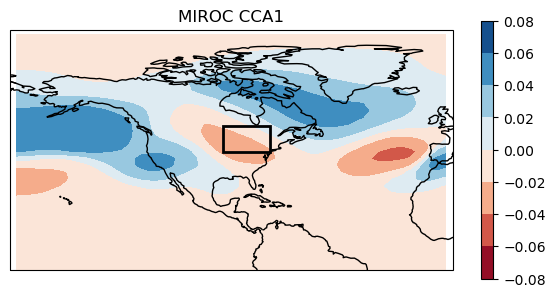

In [36]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 2)
gs.update(wspace=0.1, hspace=0.15)

ax2 = fig.add_subplot(gs[0,1],  projection=ccrs.PlateCarree())
x1, y1 = np.meshgrid(lon_zg, lat_zg)
level=np.arange(-0.08,0.1,0.02)
cs = ax2.contourf(x1, y1, BB_1,level,
                        
                        transform=ccrs.PlateCarree(),
                        cmap='RdBu')
    
cb=fig.colorbar(cs, ax=ax2, shrink=0.8, aspect=20)    
ax2.coastlines()
ax2.set_global()
ax2.set_extent([-180,0,-7.5,90],crs=ccrs.PlateCarree())
ax2.set_title('MIROC CCA1')

ax2.add_patch(rect)

fig.savefig('CCA1_basin_miroc')

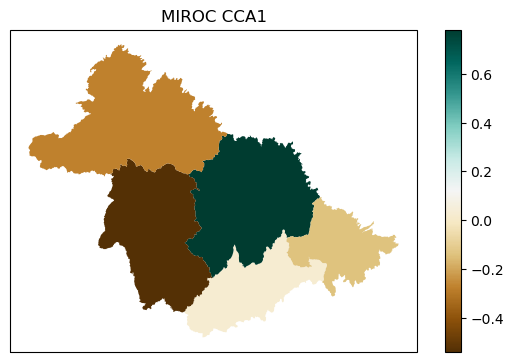

In [38]:
fig2 = plt.figure()
gs = gridspec.GridSpec(2, 2)
gs.update(wspace=0.1, hspace=0.15)

ax1 = fig2.add_subplot(gs[0,1],  projection=ccrs.PlateCarree())
shapefile.plot(ax=ax1,column ="cca1", cmap = reversed_map,legend=True)
ax1.set_title('MIROC CCA1')
fig2.savefig('miroc_pr')

In [18]:
a_c /= a_c.std(axis=0)
b_c /= b_c.std(axis=0)

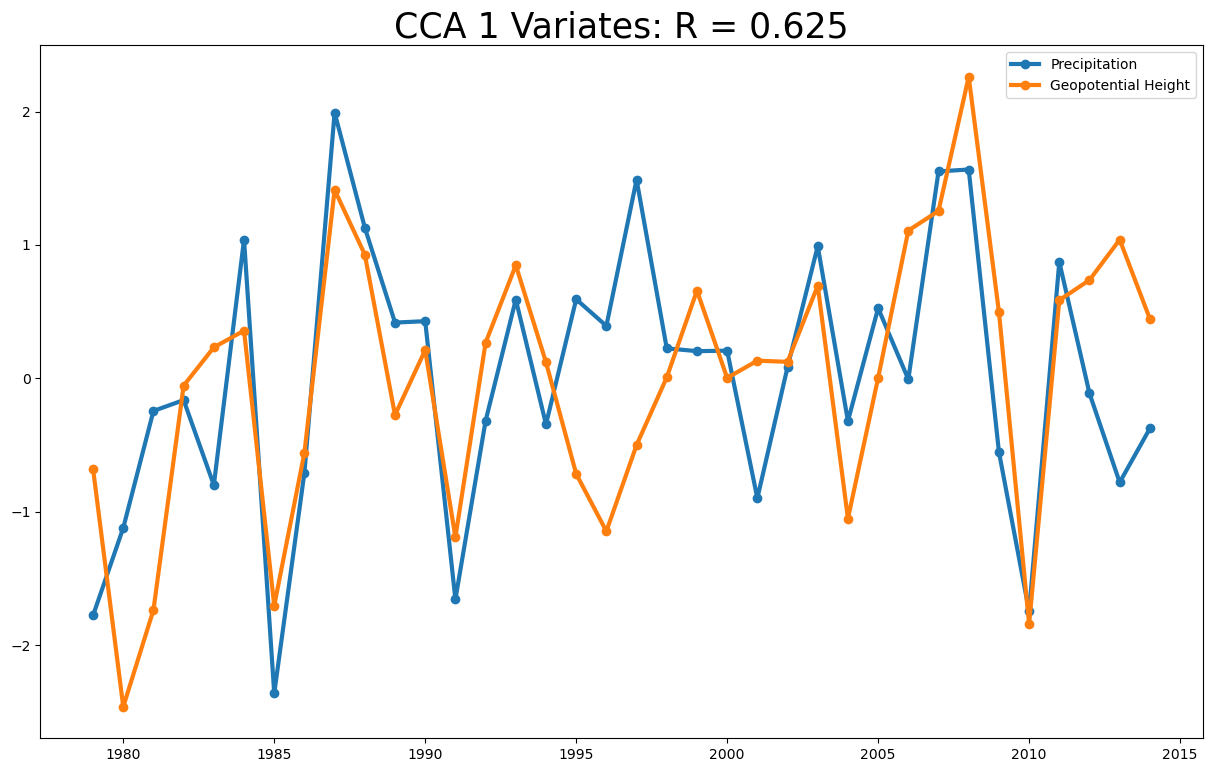

In [20]:
year = list(range(1979,2015))
fontsize = 25
plt.plot(year, a_c[:,0],"-o", label='Precipitation',linewidth=3)
plt.plot(year, b_c[:,0],"-o", label='Geopotential Height',linewidth=3)
plt.title('CCA 1 Variates: R = ' + str(round(r[0,1],3)),fontdict={'fontsize': fontsize})

plt.legend()
plt.savefig('basin_miroc')

In [21]:
cca_corr= cca.coef_


C:\Users\tameem\AppData\Roaming\Python\Python38\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


In [22]:
cca_eigenvalues = np.diag(cca_corr @ cca_corr.T)
cca_variance_ratio = cca_eigenvalues / np.sum(cca_eigenvalues)

In [24]:
cca_variance_ratio

array([0.34857362, 0.24415681, 0.05485961, 0.26699978, 0.08541018])

In [23]:
cca_eigenvalues

array([1.98409766, 1.3897522 , 0.31226354, 1.51977546, 0.48615881])